In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

import segmentation_models_pytorch as smp

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn import preprocessing as p


from PIL import Image, ImageOps
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    #os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, mode=None, transform=None, resize=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.mode = mode
        self.transform = transform
        self.resize = resize

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]  # get image
        img = self.convert_to_rgb(image)
        label = self.labels[idx]  # get label
        data_point = self.data.iloc[idx].to_dict()  # get data

        # transform
        if self.transform is not None:
            img = img.transpose(1, 2, 0)
            img = img.astype(np.float32)
            #print(type(img), img.shape, img.dtype)
            transformed = self.transform(image=img, mask=label)
            img = transformed['image']
            label = transformed['mask']
            #print(type(img), img.shape, img.dtype)
        
        # must be transformed back into (45, 45, 3) to resize
        #img = img.transpose(1, 2, 0)
        #resized = self.resize(image=img, mask=label)
        #img = resized['image']
        #label = resized['mask']
        #print(img.shape)

        sample = {'image': img, 'label': label,
                  'img': image, 'data': data_point}

        return sample

    def normalize_image(self, image):
        """
        IMPORTANT: normalizes RGB np array between 0 and 255 -- NOT 0 and 1
        """
        normed = np.empty((3, 45, 45))
        
        MIN = np.min(image)
        MAX = np.max(image)
        for img in range(3):
            flat = image[img].flatten(order='C')
            for i in range(len(flat)):
                flat[i] = (flat[i]-MIN)/(MAX-MIN)
#                 flat[i] = 255.0 * flat[i]

            normed[img] = np.reshape(flat, (45, 45), order='C')

        return normed
    
    
    def convert_to_rgb(self, image):
        new_image = np.empty((3, 45, 45))
        new_image = self.normalize_image(image)
        #print(new_image.shape)
#         new_image = new_image.transpose(1,2,0)
#         new_image = np.uint8(new_image)
#         new_image = Image.fromarray(new_image)
        
        return new_image

In [4]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = 'Data/' #CHTC
else:
    path = '' #local
    

npos = 20  # TESTING

num_workers = 0
num_epochs = 6

# grab data
hdu_list = fits.open(path + 'labeled_file.fits')
idx = random.sample(range(len(hdu_list[1].data)), npos)

images = hdu_list[1].data[idx,:] 
images = images.astype(np.float32)

sources = hdu_list[2].data[idx,:] 
sources = images.astype(np.float32)

labels = hdu_list[5].data[idx,:] 
labels = labels.astype(np.float32)

data = pd.DataFrame(hdu_list[7].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()
      
print(images.shape, labels.shape)

(20, 3, 45, 45) (20, 45, 45)


In [5]:
resize_transform = A.Compose([A.Resize(96, 96), ToTensorV2()])

In [6]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None, resize=resize_transform):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    #y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=augs, resize=resize_transform),
            ImageDataset(test_images, test_data, test_labels, transform=None, resize=resize_transform))

In [7]:
augs = A.Compose([
    A.OneOf([ A.ElasticTransform(alpha = 45*0.03, sigma = 45*0.39, alpha_affine =45*0.13)
        #alpha = 45*3, sigma = 45*0.07, alpha_affine = 45*0.09) #34, 4
#              A.GridDistortion(),
#              A.OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=1.)])

train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2, transform=augs)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data,
                                                       other_dataset.labels, test_size=0.5,
                                                       transform=transforms)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 16, len test dataset: 2


In [8]:
def show_training_set(train_dataset, idx):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    sample = train_dataset[idx]
    orig_img, tran_img, label_img = sample['img'], sample['image'], sample['label']
    tran_img = tran_img.transpose(2, 0, 1)
    print(orig_img.shape, tran_img.shape, label_img.shape)
    
    orig_rgb = make_lupton_rgb(orig_img[2],
                               orig_img[1],
                               orig_img[0], Q=11., stretch=40.)
    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    new_rgb = make_lupton_rgb(tran_img[2],
                              tran_img[1],
                              tran_img[0], stretch=.5, Q=4.)
    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    ax[2].set_title('Training Label')
    ax[2].xaxis.set_ticklabels([])
    ax[2].yaxis.set_ticklabels([])
    ax[2].imshow(label_img, aspect='equal')

    plt.show()
    plt.close()

(3, 45, 45) (3, 45, 45) (45, 45)


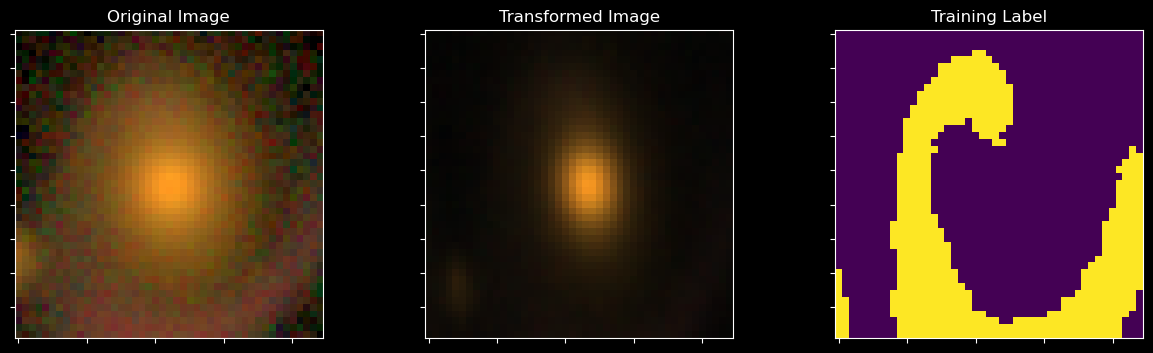

(3, 45, 45) (3, 45, 45) (45, 45)


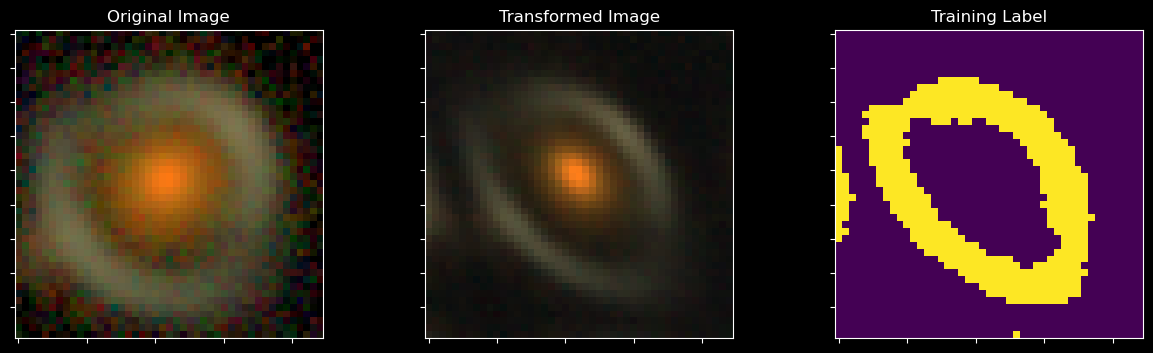

(3, 45, 45) (3, 45, 45) (45, 45)


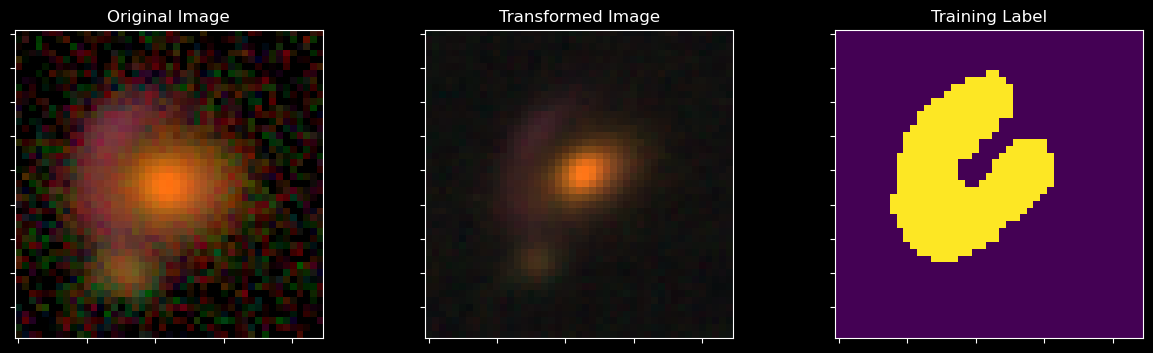

(3, 45, 45) (3, 45, 45) (45, 45)


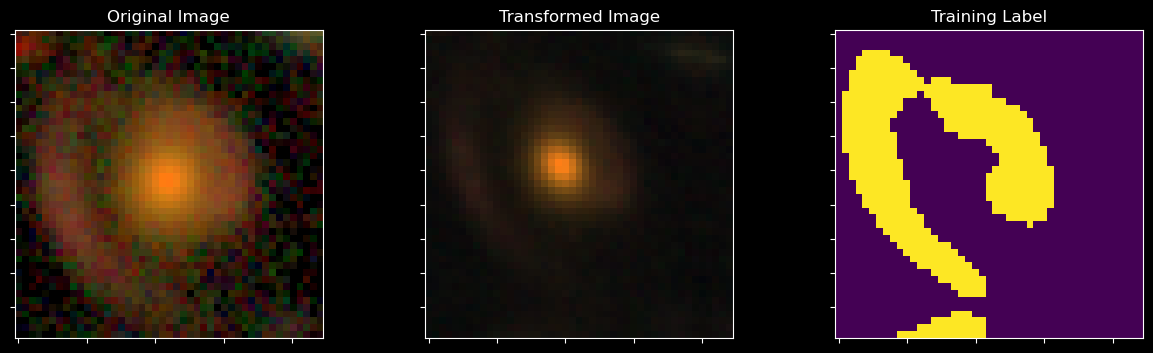

(3, 45, 45) (3, 45, 45) (45, 45)


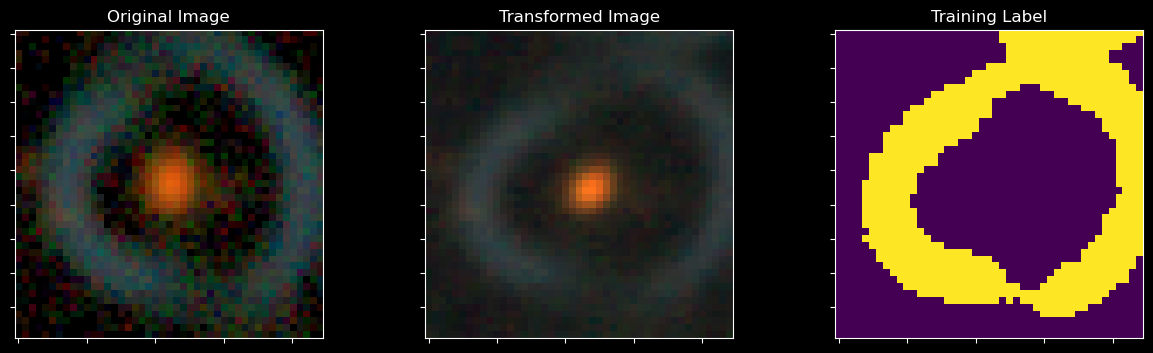

(3, 45, 45) (3, 45, 45) (45, 45)


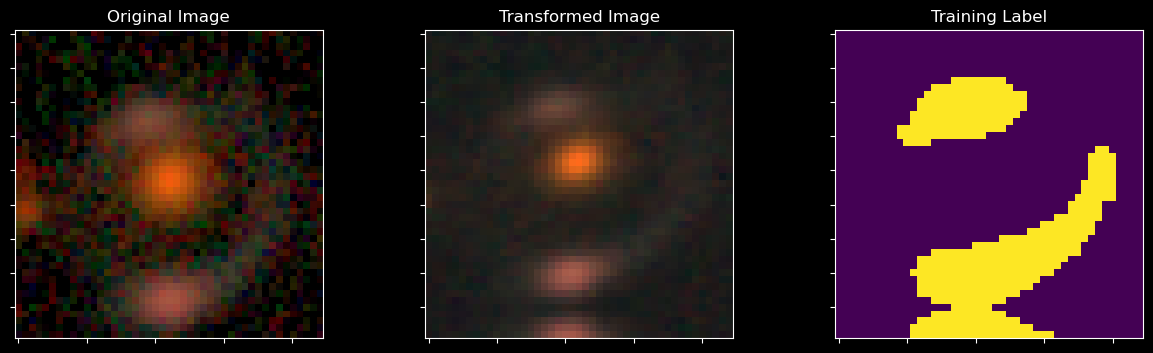

(3, 45, 45) (3, 45, 45) (45, 45)


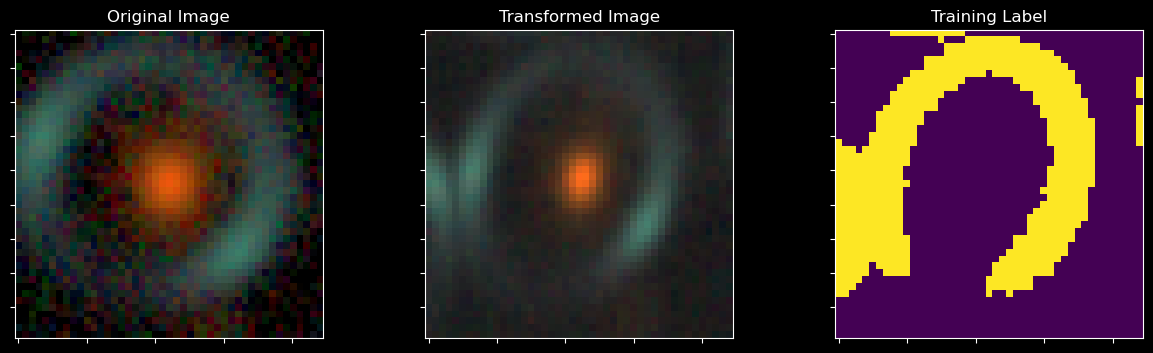

(3, 45, 45) (3, 45, 45) (45, 45)


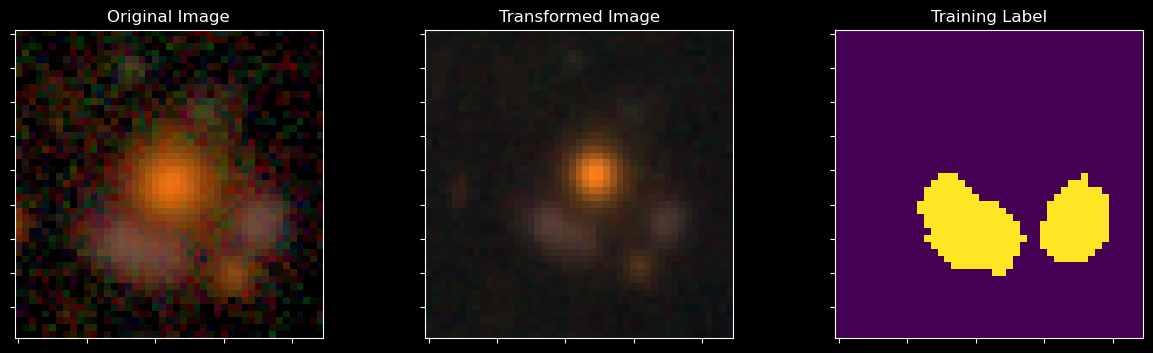

(3, 45, 45) (3, 45, 45) (45, 45)


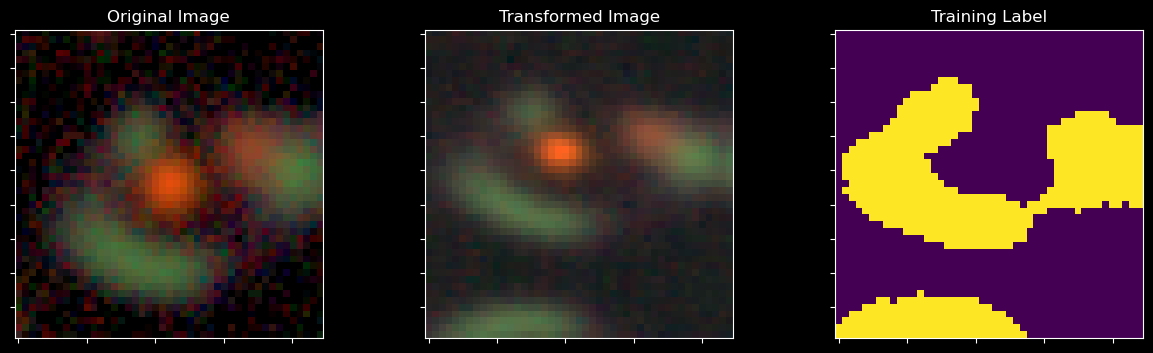

(3, 45, 45) (3, 45, 45) (45, 45)


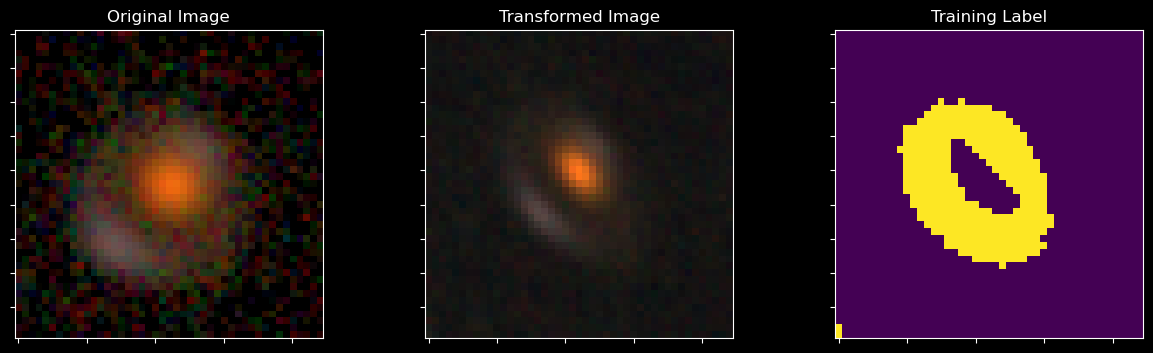

(3, 45, 45) (3, 45, 45) (45, 45)


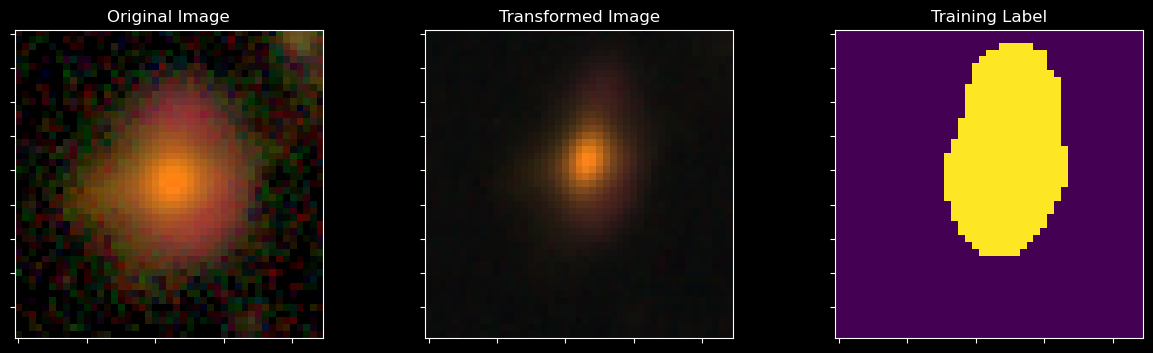

(3, 45, 45) (3, 45, 45) (45, 45)


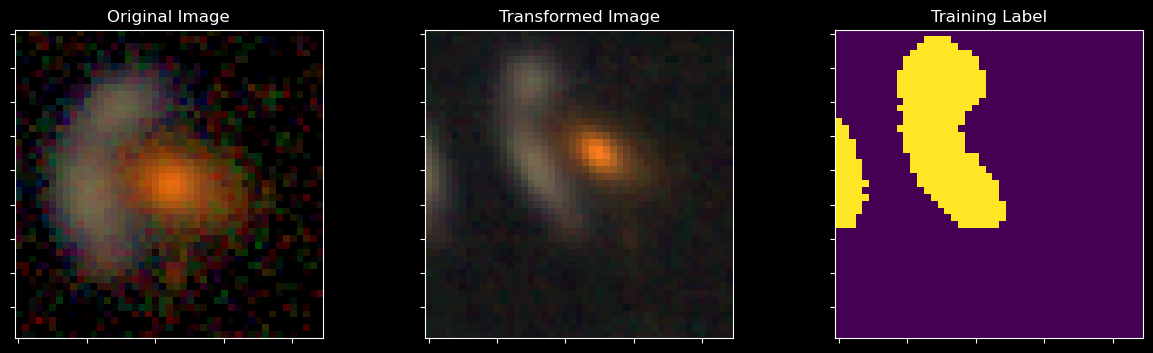

(3, 45, 45) (3, 45, 45) (45, 45)


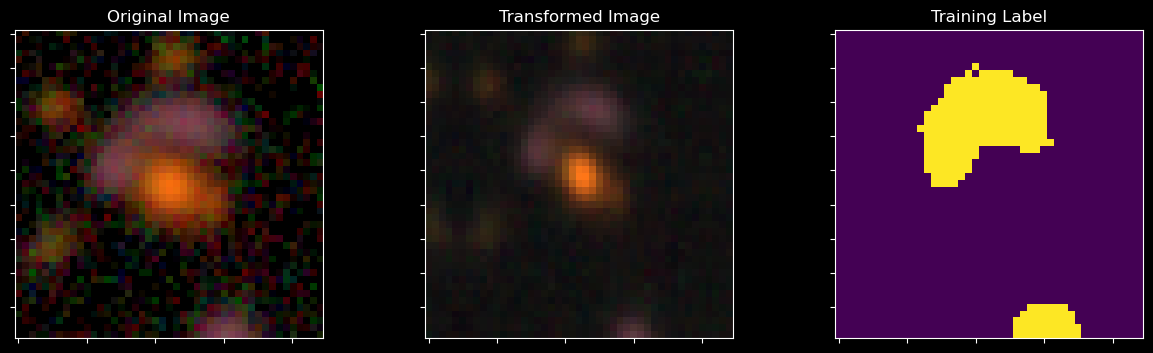

(3, 45, 45) (3, 45, 45) (45, 45)


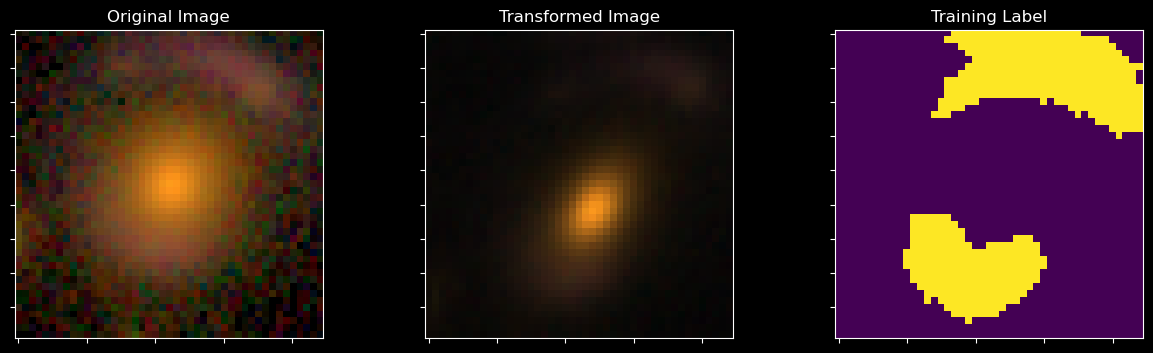

(3, 45, 45) (3, 45, 45) (45, 45)


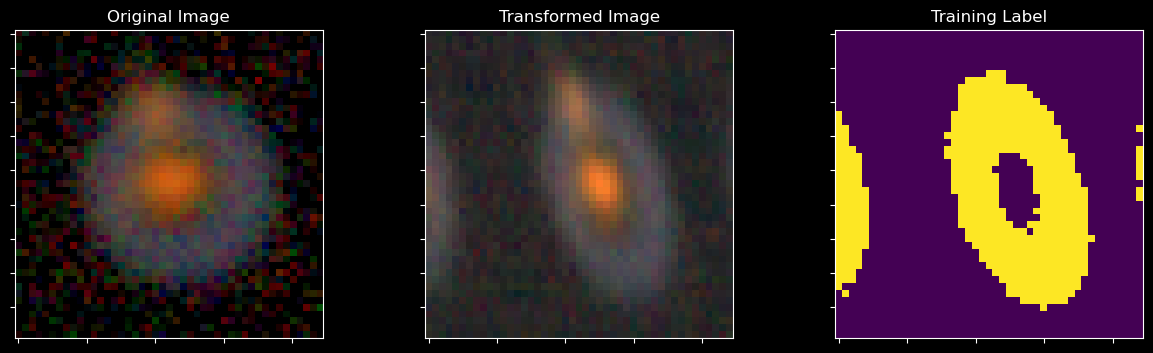

In [9]:
for idx in range(15):
    show_training_set(train_dataset, idx)